# Garbage Classification Project

### 1. Setup & Imports

In [ ]:
%pip install -q kaggle
%pip install -q keras
%pip install tensorflow
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q scikit-learn
%pip install -q pandas
%pip install -q numpy

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### 2. Download Dataset

Download the dataset from Kaggle (requires [Kaggle API setup](https://github.com/Kaggle/kaggle-api#api-credentials)).


In [5]:
# !kaggle datasets download mostafaabla/garbage-classification
# !unzip -q garbage-classification.zip -d data/

### 3. Data Exploration


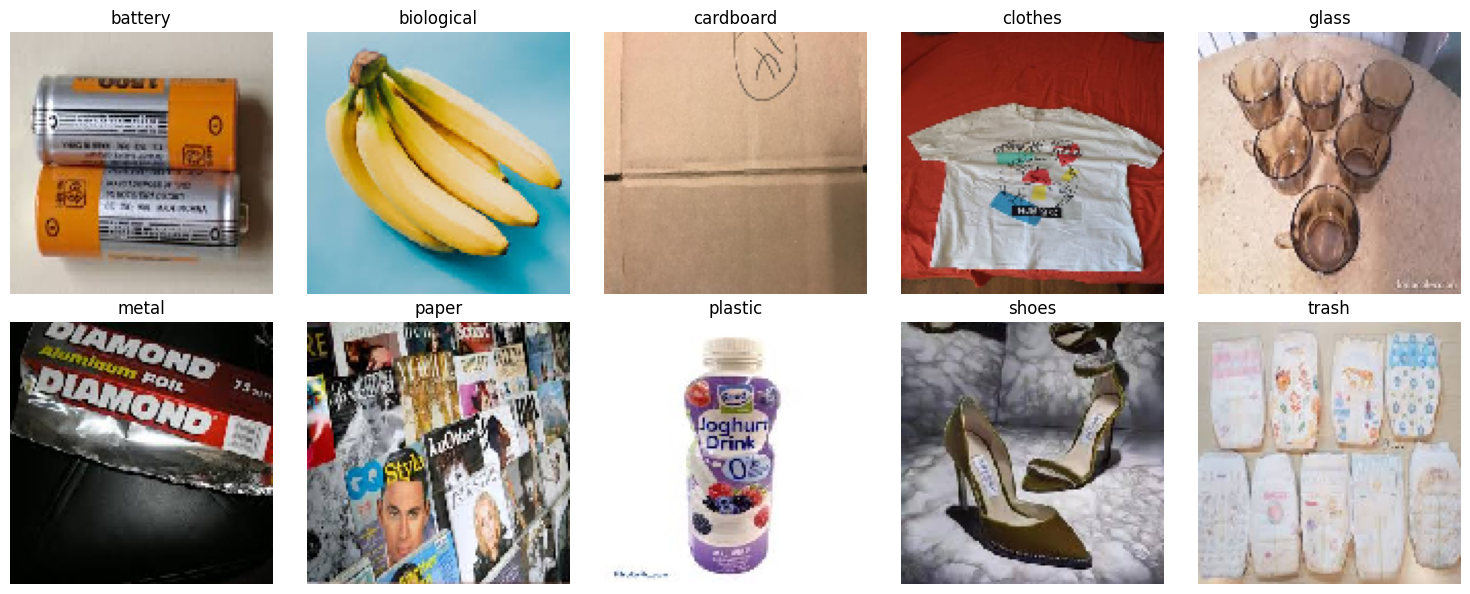

In [ ]:
import os
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

data_dir = 'Garbage_Classification_Github/data/train'
categories = os.listdir(data_dir)

plt.figure(figsize=(15, 6))
for idx, cat in enumerate(categories):
    cat_dir = os.path.join(data_dir, cat)
    img_files = os.listdir(cat_dir)
    if not img_files:
        continue 
    img_path = os.path.join(cat_dir, img_files[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4. Data Generators & Augmentation

In [ ]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 7302 images belonging to 10 classes.
Found 1822 images belonging to 10 classes.


### 5. Build the Transfer Learning Model

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 6. Train the Model

In [9]:
EPOCHS = 10
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)

c:\Users\Dell\Downloads\Garbage_Classification_Github\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1407s 6s/step - accuracy: 0.6215 - loss: 1.1742 - val_accuracy: 0.8189 - val_loss: 0.5392
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1300s 6s/step - accuracy: 0.8726 - loss: 0.3829 - val_accuracy: 0.8507 - val_loss: 0.4485
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1369s 6s/step - accuracy: 0.9014 - loss: 0.3136 - val_accuracy: 0.8633 - val_loss: 0.4171
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1273s 6s/step - accuracy: 0.9147 - loss: 0.2735 - val_accuracy: 0.8600 - val_loss: 0.4301
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1244s 5s/step - accuracy: 0.9178 - loss: 0.2622 - val_accuracy: 0.8578 - val_loss: 0.4165
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 888s 4s/step - accuracy: 0.9244 - loss: 0.2269 - val_accuracy: 0.8650 - val_loss: 0.4139
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 700s 3s/step - accuracy: 0.9345 - loss: 0.1926 - val_accuracy: 0.8732 - val_loss: 0.3818
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - accuracy: 0.9274 - loss: 0.2074 - val

### 7. Plot Training History

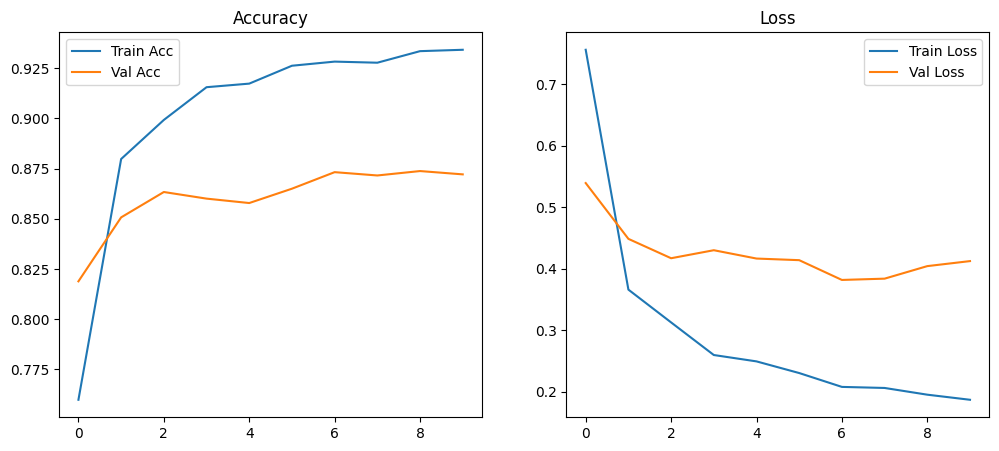

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

### 8. Evaluate Model & Confusion Matrix

57/57 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
              precision    recall  f1-score   support

     battery       0.93      0.90      0.91       189
  biological       0.94      0.97      0.95       197
   cardboard       0.93      0.90      0.92       178
     clothes       0.95      0.98      0.96       219
       glass       0.71      0.60      0.65       160
       metal       0.71      0.84      0.77       153
       paper       0.88      0.93      0.90       210
     plastic       0.80      0.76      0.78       173
       shoes       0.96      0.96      0.96       204
       trash       0.94      0.86      0.90       139

    accuracy                           0.88      1822
   macro avg       0.87      0.87      0.87      1822
weighted avg       0.88      0.88      0.88      1822



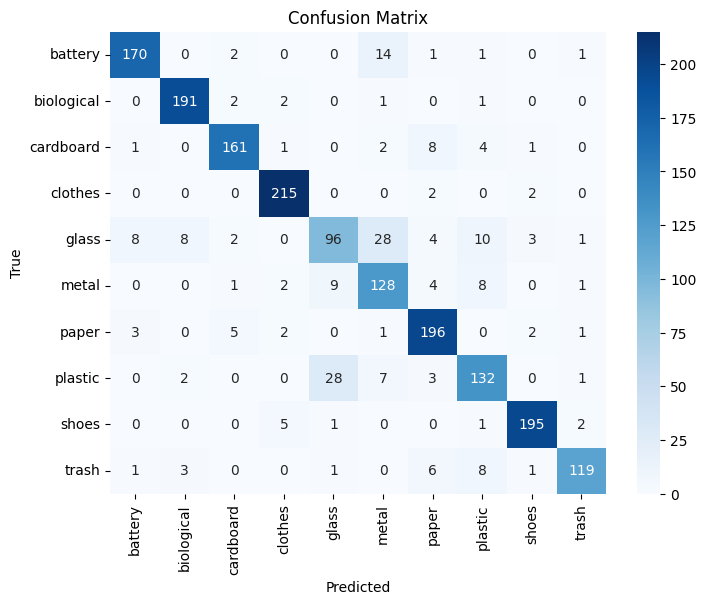

In [ ]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 7.  Final Testing and Save the Model

Found 10 images belonging to 10 classes.


c:\Users\Dell\Downloads\Garbage_Classification_Github\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step


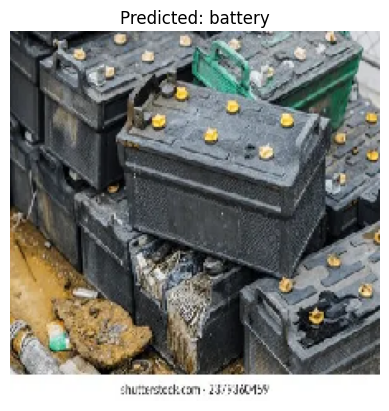

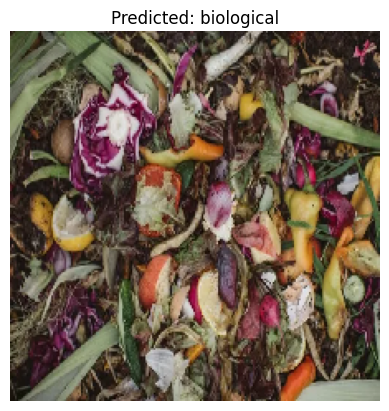

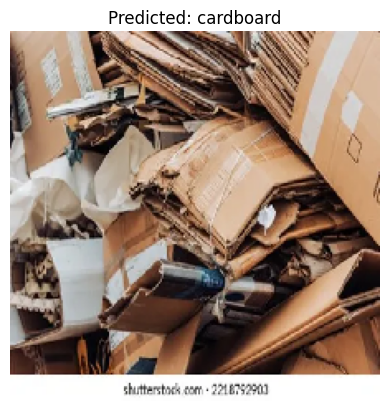

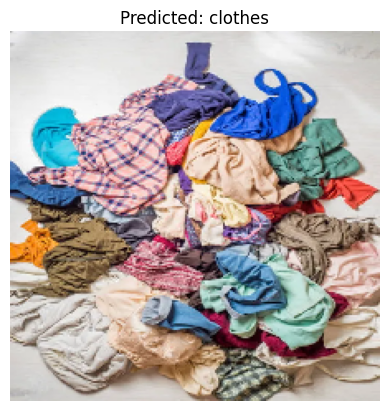

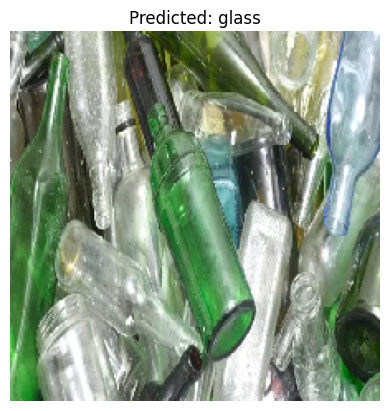

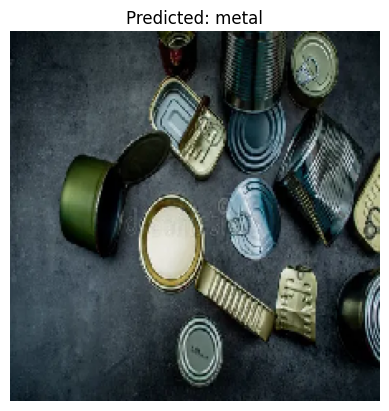

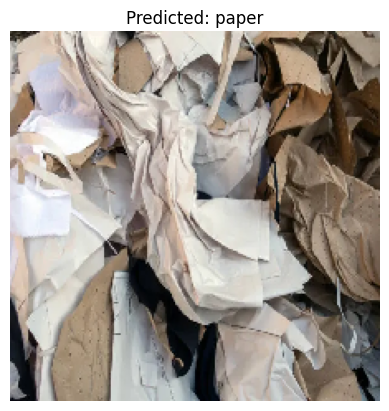

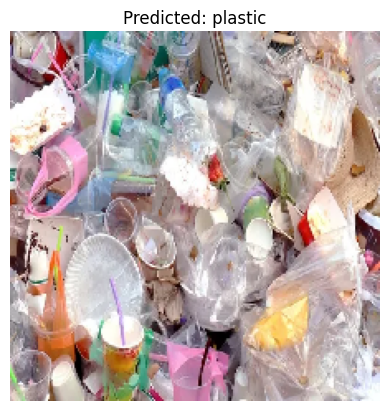

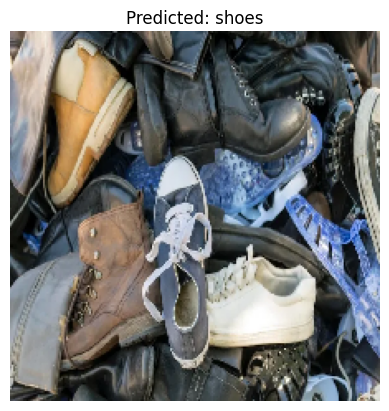

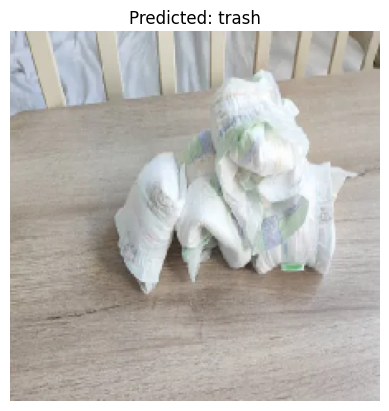

In [ ]:
model.save('Garbage_Classification_Github/models/garbage_classification_model.keras')

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory('Garbage_Classification_Github/test_dataset', target_size=(224, 224), batch_size=1, class_mode='categorical', shuffle=False)

predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)

for i in range(len(test_gen)):
    img = test_gen[i][0][0]
    plt.imshow(img)
    plt.title(f'Predicted: {labels[np.argmax(predictions[i])]}')
    plt.axis('off')
    plt.show()

### 8. Deployment

In [53]:
import os
import sys
from flask import Flask, request, render_template_string
from threading import Thread

project_root = r'C:\Users\Dell\Downloads\Garbage_Classification_Github' 

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.predict import predict_image

train_dir = os.path.join(project_root, 'data', 'train')
class_labels = sorted(next(os.walk(train_dir))[1])
class_indices = {cls: idx for idx, cls in enumerate(class_labels)}

HTML = """
<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <title>Garbage Classification</title>
    <link rel="icon" href="https://cdn-icons-png.flaticon.com/512/679/679922.png">
    <style>
      body { background: #f8f9fa; }
      .container { max-width: 500px; margin-top: 60px; }
      .card { box-shadow: 0 2px 8px rgba(0,0,0,0.08); }
      .prediction { font-size: 1.2rem; }
      .image-preview { 
        max-width: 100%; 
        max-height: 300px; 
        border-radius: 8px; 
        box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        display: none;
        margin: 0 auto;
        object-fit: contain;
      }
      .preview-container {
        text-align: center;
        margin: 20px 0;
        display: flex;
        justify-content: center;
        align-items: center;
      }
    </style>
  </head>
  <body>
    <div class="container">
      <div class="text-center mb-4">
        <img src="https://cdn-icons-png.flaticon.com/512/679/679922.png" width="60" alt="Garbage Icon">
        <h2 class="mt-2">Garbage Classification</h2>
        <p class="text-muted">Upload an image to classify its garbage type</p>
      </div>
      <div class="card p-4">
        <form method="post" enctype="multipart/form-data">
          <div class="mb-3">
            <input class="form-control" type="file" name="file" id="fileInput" accept="image/*" required>
          </div>
          <div class="preview-container">
            <img id="imagePreview" class="image-preview" alt="Image Preview">
          </div>
          <button class="btn btn-primary w-100" type="submit">Classify</button>
        </form>
        {% if prediction %}
          <div class="alert alert-success mt-4 text-center prediction">
            <strong>Prediction:</strong> {{ prediction }}<br>
            <span class="text-secondary">Confidence: {{ confidence }}%</span>
          </div>
        {% endif %}
        {% if error %}
          <div class="alert alert-danger mt-4 text-center">
            <strong>Error:</strong> {{ error }}
          </div>
        {% endif %}
      </div>
      <footer class="text-center mt-4 text-muted" style="font-size:0.9rem;">&copy; 2025 Garbage Classifier by Princee</footer>
    </div>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/js/bootstrap.bundle.min.js"></script>
    <script>
      document.getElementById('fileInput').addEventListener('change', function(event) {
        const file = event.target.files[0];
        const preview = document.getElementById('imagePreview');
        if (file) {
          const reader = new FileReader();
          reader.onload = function(e) {
            preview.src = e.target.result;
            preview.style.display = 'block';
          };
          reader.readAsDataURL(file);
        } else {
          preview.style.display = 'none';
        }
      });
    </script>
  </body>
</html>
"""

app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    confidence = None
    error = None
    if request.method == 'POST':
        file = request.files['file']
        if file:
            filepath = os.path.join(project_root, f"temp_{file.filename}")
            try:
                file.save(filepath)
                label, conf = predict_image(
                    filepath,
                    model_path=os.path.join(project_root, 'models', 'garbage_classifier.h5'),
                    img_size=(224,224),
                    class_indices=class_indices
                )
                prediction = label
                confidence = round(float(conf) * 100, 2)
            except Exception as e:
                error = str(e)
            finally:
                if os.path.exists(filepath):
                    os.remove(filepath)
    return render_template_string(HTML, prediction=prediction, confidence=confidence, error=error)

def run_flask():
    app.run(debug=True, use_reloader=False)

if 'flask_thread' not in globals():
    from threading import Thread
    flask_thread = Thread(target=run_flask)
    flask_thread.setDaemon(True)
    flask_thread.start()
    print("Flask app is running! Visit http://127.0.0.1:5000/ in your browser.")
else:
    print("Flask app is already running.")

Flask app is already running.


![app ss](<assets/Screenshot(151).png>)

![app ss](<assets/Screenshot(152).png>)